In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow

from datetime import datetime

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pyod.models.lof import LOF 
from pyod.models.iforest import IForest
from pyod.models.mad import MAD
#from pyod.models.auto_encoder import AutoEncoder


In [19]:
data = pd.read_csv('../data/raw/AW_rhr.csv')
data.head()


,Device,Start_Date,Start_Time,Value
0,AppleWatch,2026-01-03,06:13:06,77
1,AppleWatch,2026-01-03,06:13:15,75
2,AppleWatch,2026-01-03,06:26:04,87
3,AppleWatch,2026-01-03,06:26:10,90
4,AppleWatch,2026-01-03,06:29:26,81


In [20]:
data['datetime'] = data['Start_Date'] + ' ' + data['Start_Time']

In [21]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [22]:
df = data.drop(columns=['Device', 'Start_Date', 'Start_Time'])

In [23]:
df

,Value,datetime
0,77,2026-01-03 06:13:06
1,75,2026-01-03 06:13:15
2,87,2026-01-03 06:26:04
3,90,2026-01-03 06:26:10
4,81,2026-01-03 06:29:26
...,...,...
47713,73,2026-04-25 18:24:54
47714,75,2026-04-25 18:25:56
47715,86,2026-04-25 20:01:30
47716,90,2026-04-25 20:05:46


/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


<AxesSubplot:ylabel='Value'>

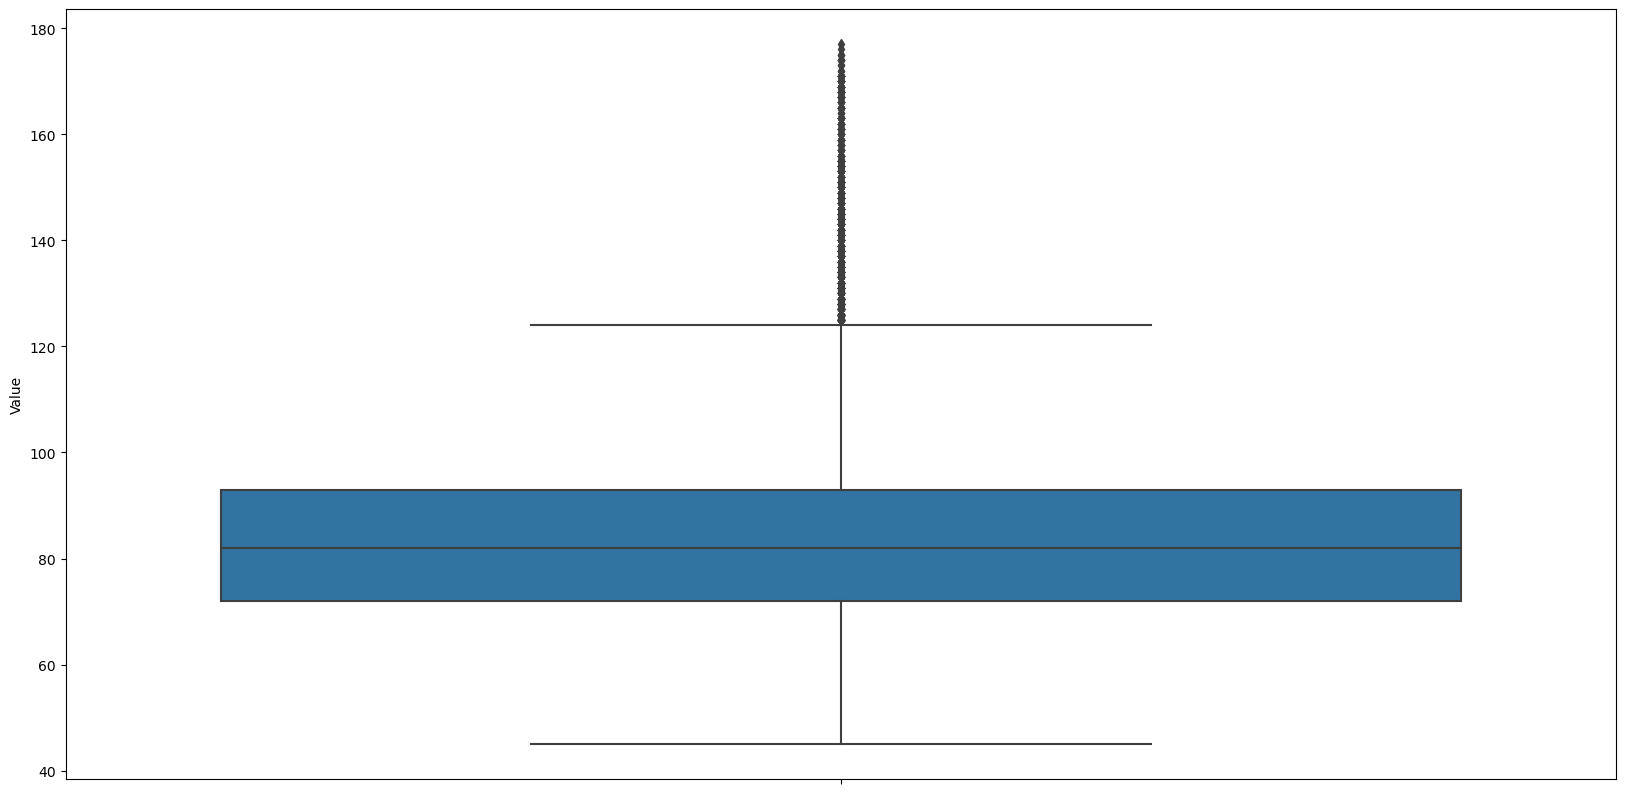

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, y='Value', orient='h')

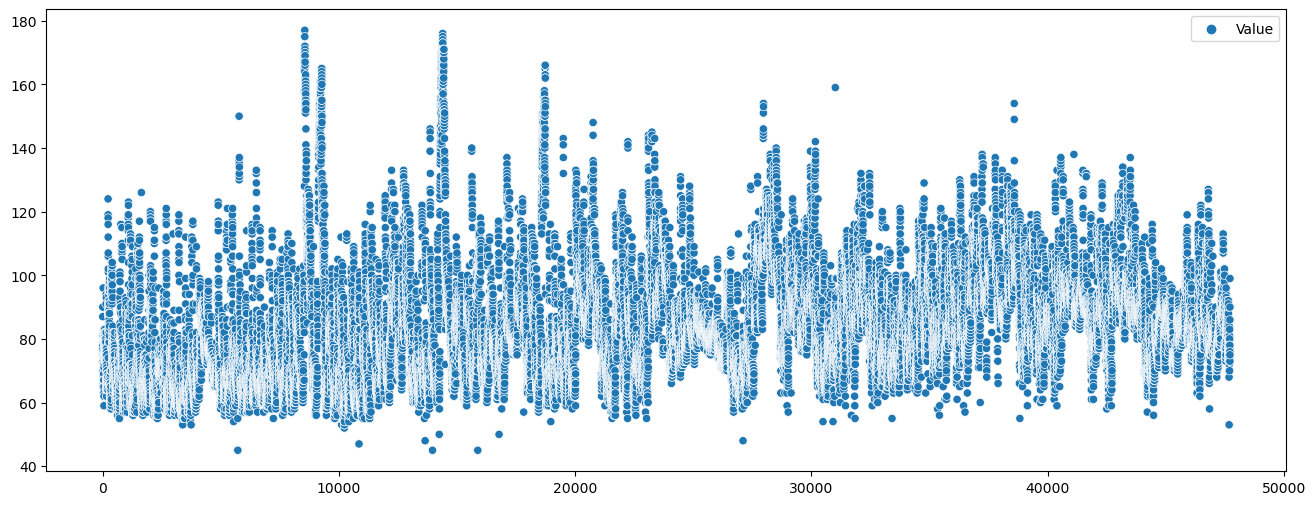

In [25]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, marker=".");

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


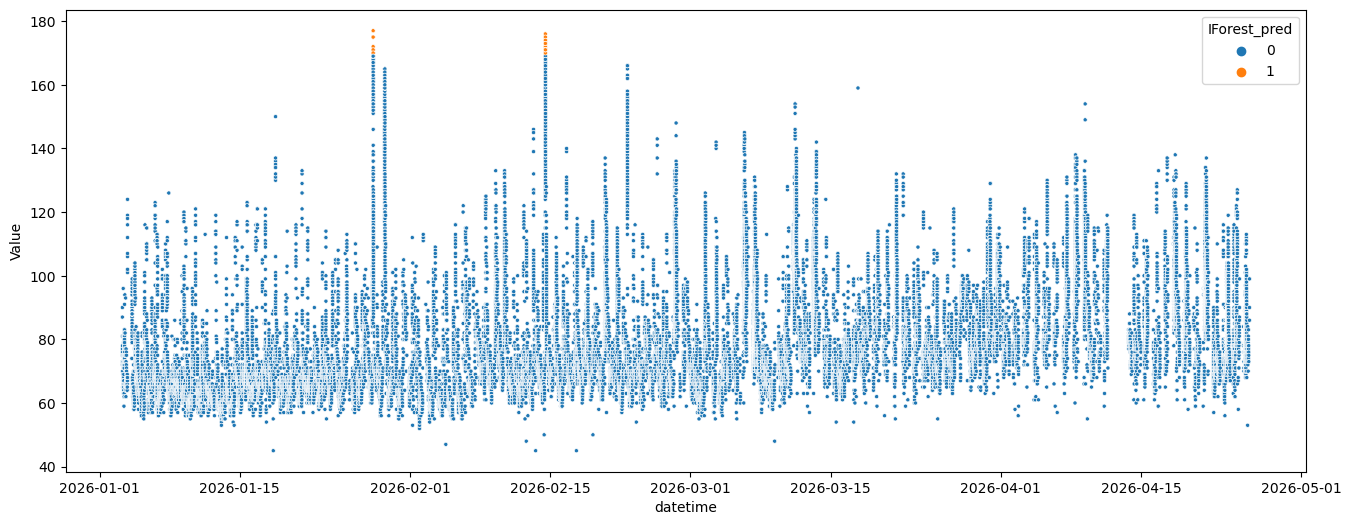

In [43]:
model = IForest(contamination=0.001)
df['IForest_pred'] = model.fit_predict(df[['Value']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x='datetime', y='Value', hue='IForest_pred', marker=".");

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


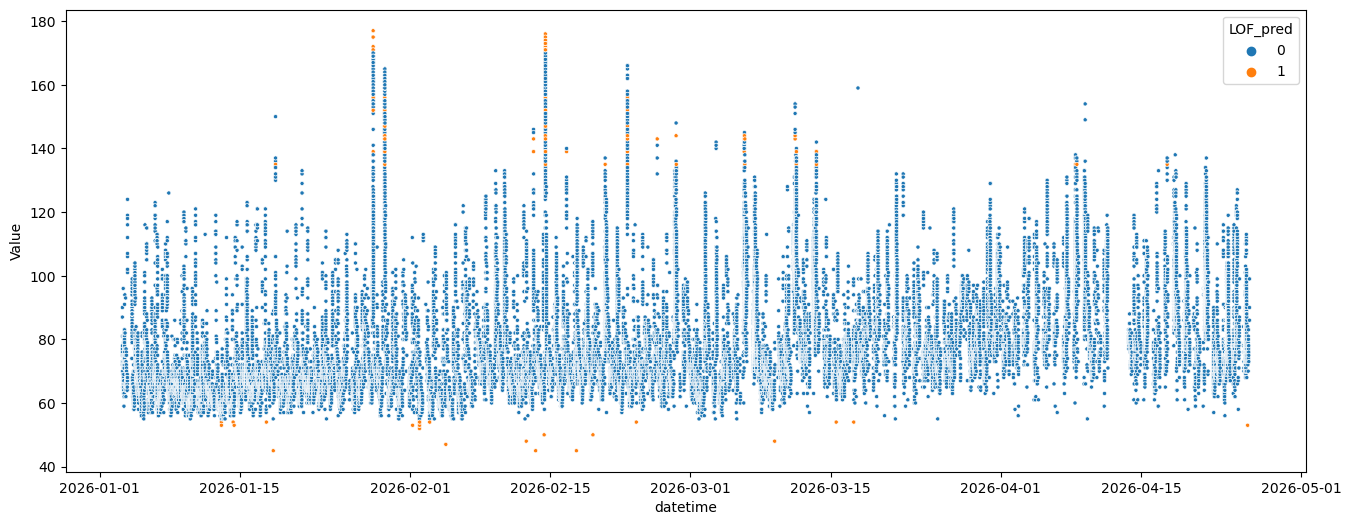

In [27]:
model = LOF()
df['LOF_pred'] = model.fit_predict(df[['Value']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x='datetime', y='Value', hue='LOF_pred', marker=".");

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


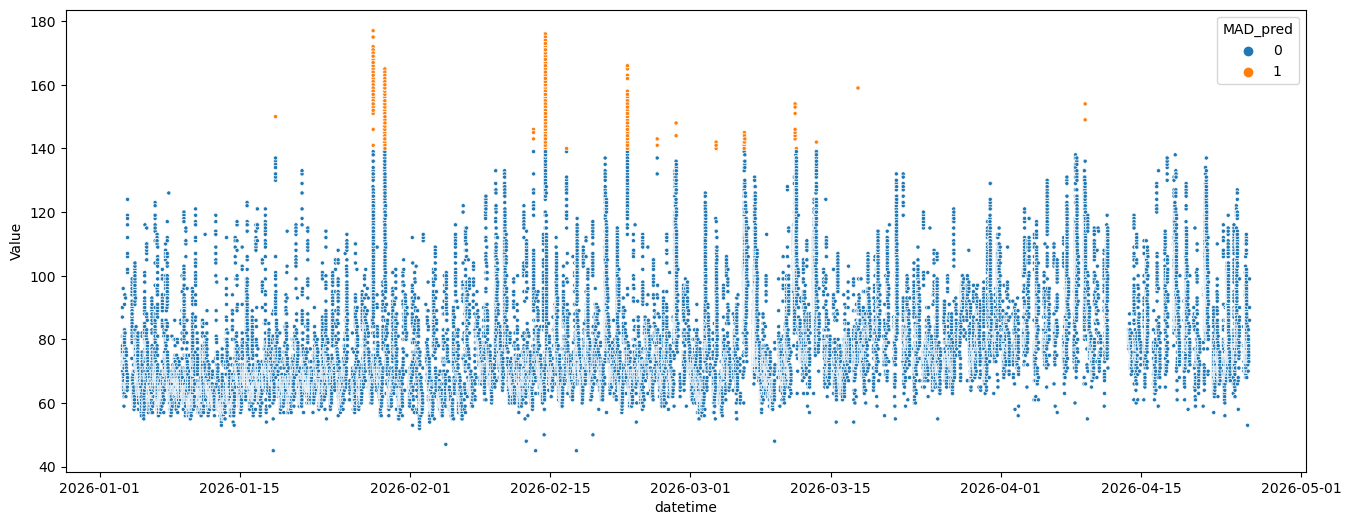

In [28]:
model = MAD()
df['MAD_pred'] = model.fit_predict(df[['Value']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x='datetime', y='Value', hue='MAD_pred', marker=".");

Cleaned Data Check

In [29]:
data2 = pd.read_csv('../data/raw/Orig_Fitbit_HR.csv')

In [30]:
data2['datetime'] = pd.to_datetime(data2['datetime'])
data2['year'] = data2['datetime'].dt.year.astype(str)
data2['month'] = data2['datetime'].dt.month.astype(str)
data2['day'] = data2['datetime'].dt.day.astype(str)

In [31]:
df_day_min = data2.groupby(['year', 'month', 'day'])['heartrate'].agg('idxmin').reset_index()
df_day_min = df_day_min.sort_values('heartrate').reset_index()
df_day_min = df_day_min.rename(columns= {'heartrate': 'index of min'})
#df_day_min.drop(columns=['index'], inplace=True)

In [37]:
time = 1000
df_final = pd.DataFrame({'Time': [], 'Temp': []})

for i in df_day_min.index:
    #find the index of the local minimum for the day as location. 
    location = data2.loc[data2.index == df_day_min['index of min'][i]].index.to_numpy()
    #Take a mean of of the temperatures before and after the min according to 'time'
    df_final.loc[i] = str(data2['datetime'].loc[location]).split()[1] + ' ' + str(data2['datetime'].loc[location]).split()[2], round(data2['heartrate'].iloc[int(location)-time:int(location)+time].mean(), 2)
    #Take the time of the min value.
    #df_final['Time'].loc[i] = df['datetime'].loc[location]
    
df_final

,Time,Temp
0,2025-11-28 02:22:41,65.76
1,2025-11-29 13:28:30,74.17
2,2025-11-30 23:53:08,59.36
3,2025-12-01 02:53:52,79.97
4,2025-12-02 19:24:00,69.72
...,...,...
179,2026-05-26 11:52:21,71.49
180,2026-05-27 14:14:58,88.02
181,2026-05-28 18:28:17,76.04
182,2026-05-29 01:32:10,77.35


/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


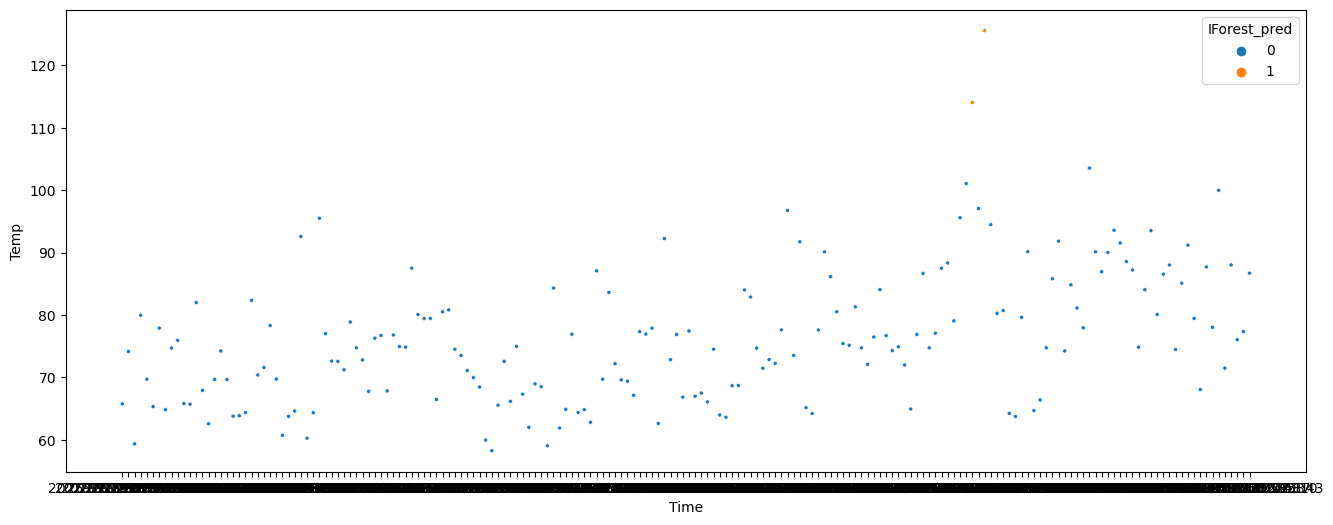

In [46]:
model = IForest(contamination=0.01)
df_final['IForest_pred'] = model.fit_predict(df_final[['Temp']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_final, x='Time', y='Temp', hue='IForest_pred', marker=".");

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


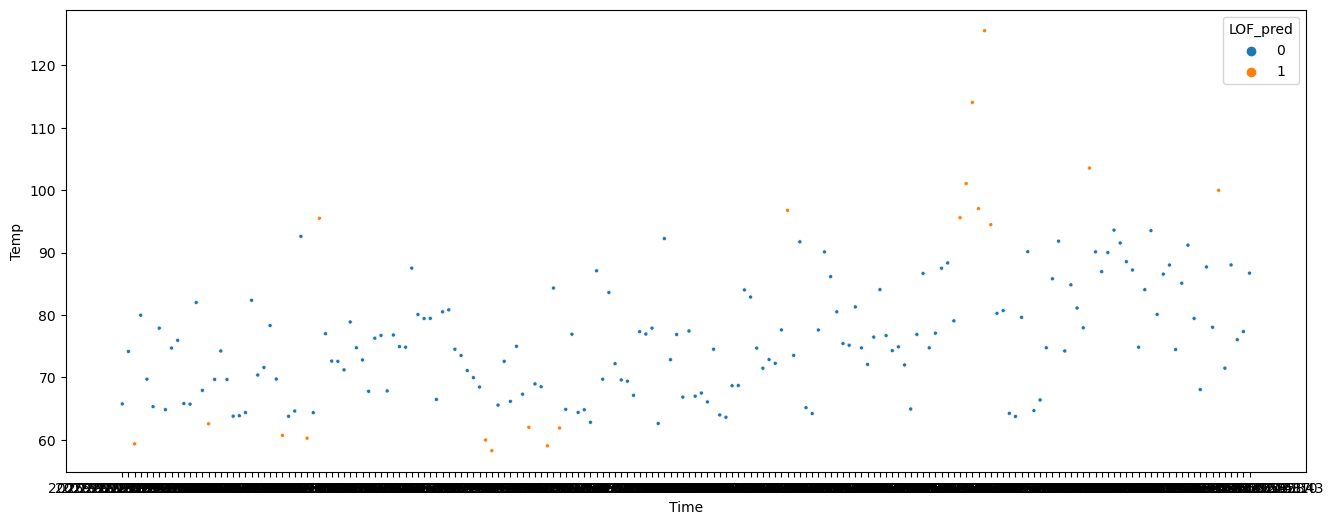

In [41]:
model = LOF()
df_final['LOF_pred'] = model.fit_predict(df_final[['Temp']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_final, x='Time', y='Temp', hue='LOF_pred', marker=".");

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


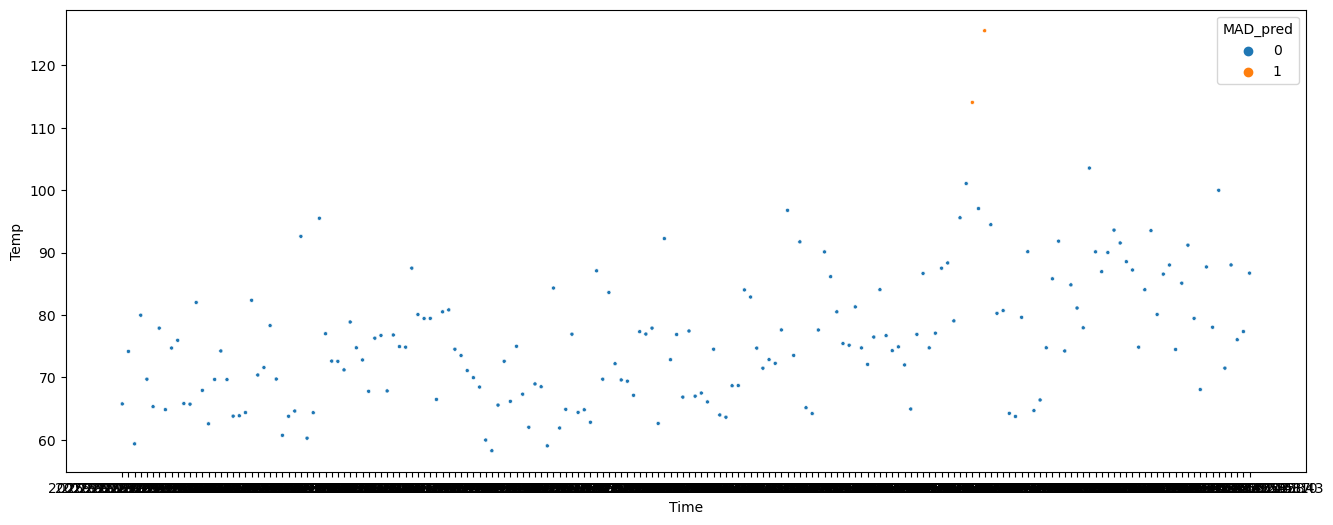

In [42]:
model = MAD()
df_final['MAD_pred'] = model.fit_predict(df_final[['Temp']])
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df_final, x='Time', y='Temp', hue='MAD_pred', marker=".");